In [36]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [37]:
df=pd.read_csv('/kaggle/input/football-players-stats-2024-2025/players_data-2024_2025.csv')

In [38]:
df=df.fillna(0)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Columns: 267 entries, Rk to AvgDist
dtypes: float64(101), int64(121), object(45)
memory usage: 5.8+ MB


In [40]:
df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Att (GK),Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,25.0,2000.0,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Max Aarons,eng ENG,"DF,MF",Valencia,es La Liga,25.0,2000.0,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,22.0,2003.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,21.0,2004.0,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,19.0,2006.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
columns=['Gls','xG','Ast','xAG','G+A']
df.loc[df['Player']=='Pedri', columns]

,Gls,xG,Ast,xAG,G+A
2050,4,2.2,5,7.4,9


In [42]:
squad=df.groupby('Squad')[columns].agg({'Gls':'sum','xG':'sum','Ast':'sum','xAG':'sum','G+A':'sum'})
squad['Expected Vs Reality']='Under'
squad.loc[(squad['Gls']-squad['xG']<0)&(squad['Ast']-squad['xAG']>0),'Expected Vs Reality']='Partial'
squad.loc[(squad['Gls']-squad['xG']>0)&(squad['Ast']-squad['xAG']<0),'Expected Vs Reality']='Partial'
squad.loc[(squad['Gls']-squad['xG']>0)&(squad['Ast']-squad['xAG']>0),'Expected Vs Reality']='Over'

In [43]:
squad=squad.sort_values(by='G+A',ascending=False)
squad.head()

,Gls,xG,Ast,xAG,G+A,Expected Vs Reality
Squad,,,,,,
Barcelona,96,89.8,71,66.4,167,Over
Bayern Munich,96,82.7,66,60.1,162,Over
Paris S-G,89,90.6,69,71.5,158,Under
Liverpool,82,79.9,62,58.3,144,Over
Real Madrid,76,74.2,54,53.6,130,Over


In [44]:
from sklearn.metrics.pairwise import cosine_similarity
scaler = StandardScaler()
features=['Gls','xG','Ast','xAG', 'npxG','Tkl' ,'TklW','Blocks','Clr','Err','PrgP','PrgC','KP','PrgR','Carries','Recov','Touches','PrgR','PPA','GA','Saves','CS','PKsv']
normalized_stats = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

#similarity matrix
similarity_matrix = cosine_similarity(normalized_stats)

#function to find most similar players
def find_similar_players(player_name, top_n=10):
    player_index = df[df['Player'] == player_name].index[0]
    similarity_scores = similarity_matrix[player_index]
    similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]  #exclude the player itself
    
    similar_players = df.iloc[similar_indices][['Player', 'Squad', 'Pos', 'Age']]
    similar_players['Similarity'] = similarity_scores[similar_indices]
    
    return similar_players

In [45]:
find_similar_players("Lamine Yamal")

,Player,Squad,Pos,Age,Similarity
2754,Iñaki Williams,Athletic Club,FW,30.0,0.979143
1153,Son Heung-min,Tottenham,FW,32.0,0.976924
212,Dilane Bakwa,Strasbourg,"MF,DF",22.0,0.975772
2620,Leandro Trossard,Arsenal,FW,30.0,0.975144
1454,Rafael Leão,Milan,FW,25.0,0.972581
2765,Florian Wirtz,Leverkusen,"MF,FW",22.0,0.971262
1951,Michael Olise,Bayern Munich,"FW,MF",23.0,0.971027
772,Désiré Doué,Paris S-G,"FW,MF",19.0,0.969799
1786,Raúl Moro,Valladolid,"MF,FW",22.0,0.969017
66,Maghnes Akliouche,Monaco,"FW,MF",23.0,0.966339


In [46]:
import pandas as pd
import numpy as np

def create_team_df(df):
    sum_metrics = [
        'Gls', 'Ast', 'xG', 'xAG', 'npxG', 
        'Tkl', 'TklW', 'Blocks', 'Clr', 'Err',
        'PrgP', 'PrgC', 'KP', 'PrgR', 'Carries', 
        'Recov', 'Touches', 'PPA', 
        'Mis', 'Dis', 'CrdY', 'CrdR', 'PKcon'
    ]
    gk_metrics = ['GA', 'Saves', 'CS', 'PKsv']

    agg_dict = {}

    for metric in sum_metrics:
        if metric in df.columns:
            agg_dict[metric] = 'sum'
    for metric in gk_metrics:
        if metric in df.columns:
            agg_dict[metric] = 'sum'
    
    if 'Comp' in df.columns:
        agg_dict['Comp'] = 'first'
    
    if 'Min' in df.columns:
        agg_dict['Min'] = 'sum'

    team_df = df.groupby('Squad').agg(agg_dict).reset_index()
    
    if 'Gls' in team_df.columns and 'xG' in team_df.columns:
        team_df['Goals_per_xG'] = team_df['Gls'] / team_df['xG'].replace(0, np.nan)
        team_df['Goals_per_xG'] = team_df['Goals_per_xG'].fillna(1)
    
    if 'Tkl' in team_df.columns and 'Blocks' in team_df.columns and 'Clr' in team_df.columns:
        team_df['Defensive_Actions'] = team_df['Tkl'] + team_df['Blocks'] + team_df['Clr']
    
    if 'PrgP' in team_df.columns and 'Touches' in team_df.columns:
        team_df['Progression_Rate'] = team_df['PrgP'] / team_df['Touches'].replace(0, np.nan)
        team_df['Progression_Rate'] = team_df['Progression_Rate'].fillna(0)
    
    if 'Mis' in team_df.columns and 'Dis' in team_df.columns and 'Touches' in team_df.columns:
        team_df['Turnover_Rate'] = (team_df['Mis'] + team_df['Dis']) / team_df['Touches'].replace(0, np.nan)
        team_df['Turnover_Rate'] = team_df['Turnover_Rate'].fillna(0)
    
    if 'CrdY' in team_df.columns and 'CrdR' in team_df.columns:
     
        team_df['Discipline_Index'] = team_df['CrdY'] + (team_df['CrdR'] * 3)
    
    return team_df

team_df = create_team_df(df)

In [47]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.projections import register_projection
import matplotlib.patches as mpatches

#features
attacking_features = ['Gls', 'xG', 'Ast', 'xAG', 'npxG', 'KP', 'PPA']
defensive_features = ['Tkl', 'TklW', 'Blocks', 'Clr', 'Err', 'GA', 'CS', 'PKsv']
possession_features = ['PrgP', 'PrgC', 'PrgR', 'Carries', 'Touches', 'Mis', 'Dis', 'Recov']
disciplinary_features = ['CrdY', 'CrdR', 'PKcon']

features = attacking_features + defensive_features + possession_features + disciplinary_features

X = StandardScaler().fit_transform(team_df[features])

kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
team_df['PlayingStyle'] = kmeans.fit_predict(X)

In [48]:
style_names = {
    0: "Direct High Pressure Football",
    1: "Possession Football",
    2: "Cautious Pass and Move Football",
    3: "Parking-the-bus Football",
    4: "Aggressive Long Ball Football",
    5: "Direct Attacking Football",
    6: "High Pressure Pass and Move Football",
    7: "Cautious Attacking Football"
}

team_df['StyleName'] = team_df['PlayingStyle'].map(style_names)

In [49]:
style=6;
col=['Squad', 'Comp', 'StyleName']
team_df.loc[team_df['PlayingStyle']==style,col]

,Squad,Comp,StyleName
4,Atalanta,it Serie A,High Pressure Pass and Move Football
9,Barcelona,es La Liga,High Pressure Pass and Move Football
10,Bayern Munich,de Bundesliga,High Pressure Pass and Move Football
51,Liverpool,eng Premier League,High Pressure Pass and Move Football
55,Manchester City,eng Premier League,High Pressure Pass and Move Football
68,Paris S-G,fr Ligue 1,High Pressure Pass and Move Football
72,Real Madrid,es La Liga,High Pressure Pass and Move Football


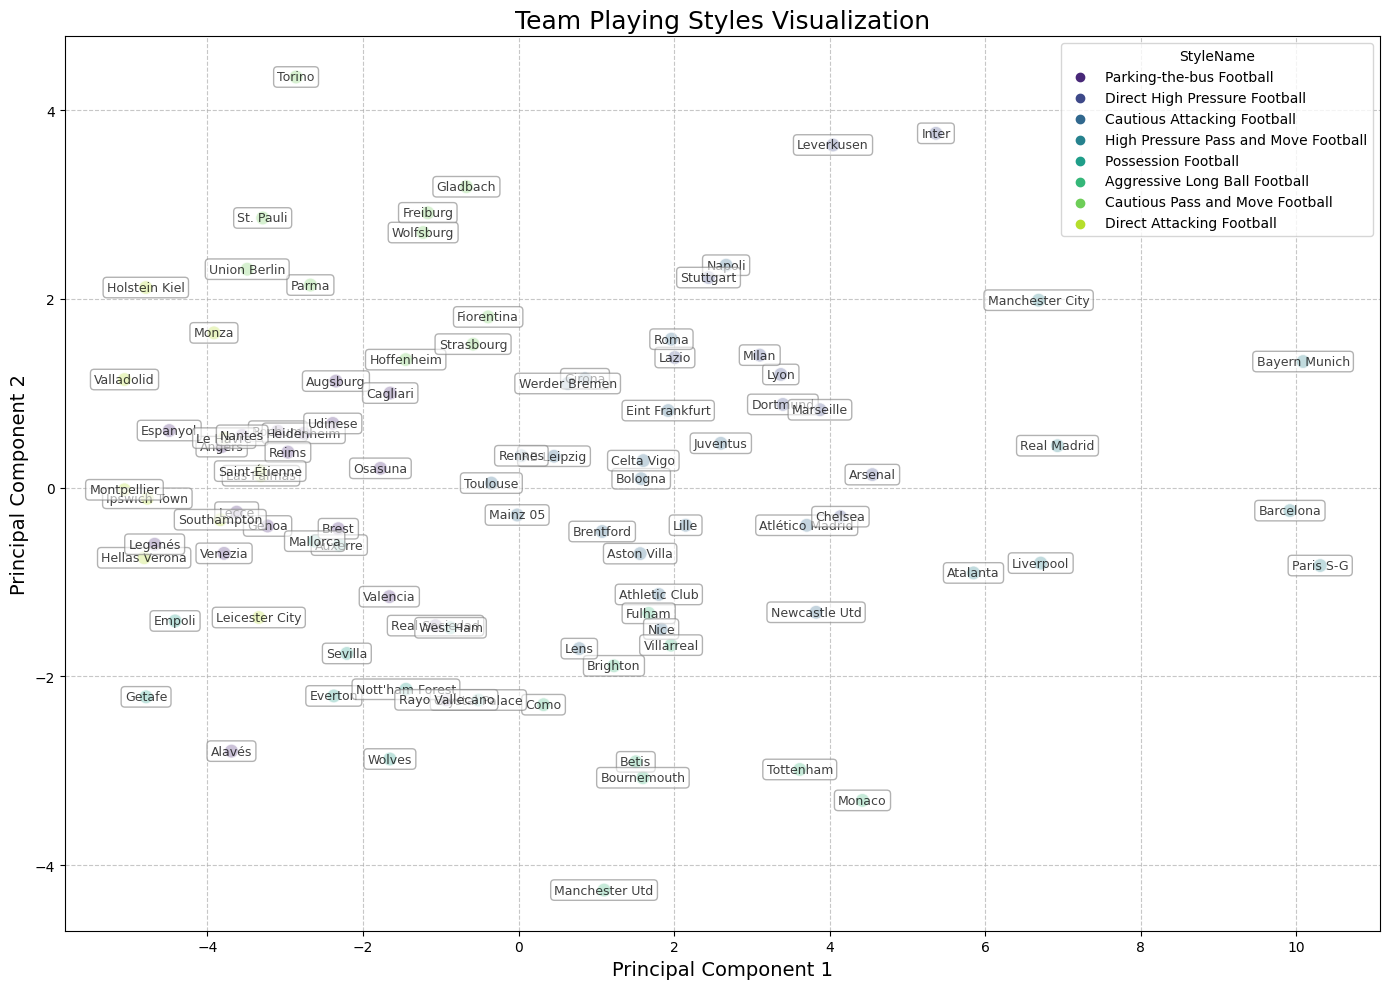

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df['PlayingStyle'] = team_df['PlayingStyle']
pca_df['StyleName'] = team_df['StyleName']
pca_df['Squad'] = team_df['Squad']

plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    x='PC1', 
    y='PC2',
    hue='StyleName',
    data=pca_df,
    palette='viridis',
    s=100,
    alpha=0.7
)

for i, row in pca_df.iterrows():
    plt.annotate(
        row['Squad'], 
        (row['PC1'], row['PC2']),
        fontsize=9,
        alpha=0.75,
        ha='center',
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.6)
    )

style_descriptions = {
    "Direct High Pressure Football": "Aggressive forward passing + intense pressing",
    "Possession Football": "High ball retention + methodical build-up",
    "Cautious Pass and Move Football": "Short passing with defensive security",
    "Parking-the-bus Football": "Deep defensive block + minimal attacking risk",
    "Aggressive Long Ball Football": "Direct long passes + strong defensive actions",
    "Direct Attacking Football": "Vertical attacking play + counter-attacking focus",
    "High Pressure Pass and Move Football": "Technical passing + aggressive pressing",
    "Cautious Attacking Football": "Balanced attack + positional discipline"
}
plt.title('Team Playing Styles Visualization', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("team_playing_styles_pca.png", dpi=300, bbox_inches='tight')
plt.show()

In [51]:
min_max_scaler = MinMaxScaler()
normalized_centers = min_max_scaler.fit_transform(kmeans.cluster_centers_)

   Style ID                            Style Name  Teams Count  \
0         0         Direct High Pressure Football           10   
1         1                   Possession Football           10   
2         2       Cautious Pass and Move Football           10   
3         3              Parking-the-bus Football           19   
4         4         Aggressive Long Ball Football            9   
5         5             Direct Attacking Football           11   
6         6  High Pressure Pass and Move Football            7   
7         7           Cautious Attacking Football           20   

                       Tactical Components         Top Metrics  \
0         Direct attacking + High pressing      PPA, Ast, CrdR   
1         Defensive football + Short plays       Tkl, Dis, Clr   
2       Pass and move + Cautious defending    PKcon, Clr, PKsv   
3  Defensive football + Cautious defending     Clr, Mis, PKcon   
4         Long ball + Aggressive defending  Tkl, Recov, Blocks   
5        

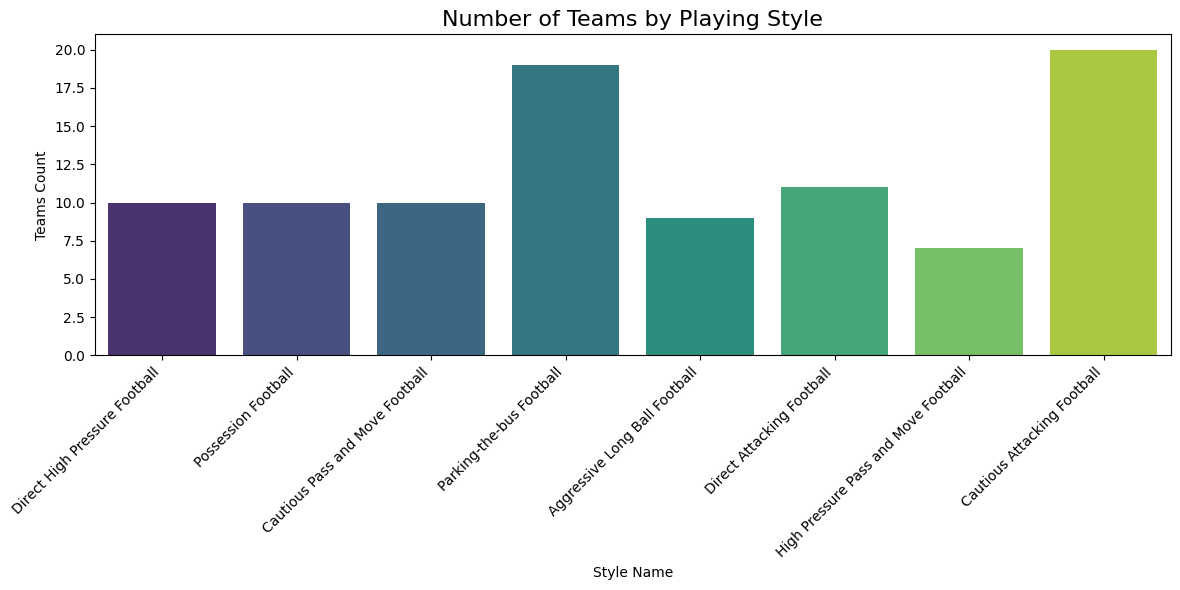

In [52]:
style_metrics = []

for style_id, style_name in style_names.items():
    
    teams_count = len(team_df[team_df['PlayingStyle'] == style_id])

    style_metrics_values = normalized_centers[style_id]

    top_indices = np.argsort(style_metrics_values)[-3:]
    bottom_indices = np.argsort(style_metrics_values)[:3]
    
    top_metrics = [features[i] for i in top_indices]
    bottom_metrics = [features[i] for i in bottom_indices]
    
    if style_id == 0:  
        tactical_components = "Direct attacking + High pressing"
    elif style_id == 1: 
        tactical_components = "Defensive football + Short plays"
    elif style_id == 2:  
        tactical_components = "Pass and move + Cautious defending"
    elif style_id == 3:  
        tactical_components = "Defensive football + Cautious defending"
    elif style_id == 4:
        tactical_components = "Long ball + Aggressive defending"
    elif style_id == 5:  
        tactical_components = "Attacking football + Direct plays"
    elif style_id == 6:
        tactical_components = "Pass and move + High pressing"
    elif style_id == 7:  
        tactical_components = "Attacking football + Cautious defending"
    
    style_metrics.append({
        'Style ID': style_id,
        'Style Name': style_name,
        'Teams Count': teams_count,
        'Tactical Components': tactical_components,
        'Top Metrics': ', '.join(top_metrics),
        'Bottom Metrics': ', '.join(bottom_metrics)
    })

style_metrics_df = pd.DataFrame(style_metrics)
print(style_metrics_df)

plt.figure(figsize=(12, 6))
sns.barplot(x='Style Name', y='Teams Count', data=style_metrics_df, palette='viridis')
plt.title('Number of Teams by Playing Style', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("teams_by_playing_style.png", dpi=300)
plt.show()

In [53]:
feature_groups = {
    'Attacking': attacking_features,
    'Defensive': defensive_features,
    'Possession': possession_features,
    'Disciplinary': disciplinary_features
}
style_profiles = []

for style_id, style_name in style_names.items():
   
    teams = team_df[team_df['PlayingStyle'] == style_id]['Squad'].tolist()
    
    
    profile = {}
    for category, category_features in feature_groups.items():
        category_values = normalized_centers[style_id][[features.index(f) for f in category_features]]
        top_idx = np.argmax(category_values)
        top_feature = category_features[top_idx]
        top_value = category_values[top_idx]
        profile[f'Top {category}'] = (top_feature, top_value)
    
   
    if profile['Top Attacking'][0] in ['Gls', 'xG', 'npxG'] and profile['Top Defensive'][0] in ['Tkl', 'TklW']:
        framework_match = "Direct High Pressure Football"
    elif profile['Top Possession'][0] in ['Touches', 'Carries'] and profile['Top Defensive'][0] in ['CS', 'Blocks']:
        framework_match = "Possession Football"
    elif profile['Top Possession'][0] in ['PrgP', 'PrgC'] and profile['Top Defensive'][0] in ['Clr', 'Blocks']:
        framework_match = "Cautious Pass and Move Football"
    elif profile['Top Defensive'][0] in ['CS', 'Clr'] and profile['Top Attacking'][0] not in ['Gls', 'xG']:
        framework_match = "Parking-the-bus Football"
    elif profile['Top Defensive'][0] in ['Tkl', 'TklW'] and profile['Top Possession'][0] in ['PrgR', 'PrgP']:
        framework_match = "Aggressive Long Ball Football"
    elif profile['Top Attacking'][0] in ['Gls', 'xG'] and profile['Top Possession'][0] in ['PrgR', 'PrgC']:
        framework_match = "Direct Attacking Football"
    elif profile['Top Possession'][0] in ['PrgP', 'PrgC'] and profile['Top Defensive'][0] in ['Tkl', 'TklW']:
        framework_match = "High Pressure Pass and Move Football"
    elif profile['Top Attacking'][0] in ['Gls', 'xG'] and profile['Top Defensive'][0] in ['CS', 'Blocks']:
        framework_match = "Cautious Attacking Football"
    else:
        framework_match = "Balanced Style (Mixed)"

    style_profiles.append({
        'Style ID': style_id,
        'Style Name': style_name,
        'Teams Count': len(teams),
        'Example Teams': ', '.join(teams[:5]) + ('...' if len(teams) > 5 else ''),
        'Framework Match': framework_match,
        'Top Attacking Metric': profile['Top Attacking'][0],
        'Top Defensive Metric': profile['Top Defensive'][0],
        'Top Possession Metric': profile['Top Possession'][0],
        'Style Description': style_descriptions[style_name]
    })

style_profiles_df = pd.DataFrame(style_profiles)
print(style_profiles_df[['Style Name', 'Framework Match', 'Teams Count', 'Example Teams', 'Style Description']])

                             Style Name              Framework Match  \
0         Direct High Pressure Football          Possession Football   
1                   Possession Football     Parking-the-bus Football   
2       Cautious Pass and Move Football       Balanced Style (Mixed)   
3              Parking-the-bus Football     Parking-the-bus Football   
4         Aggressive Long Ball Football       Balanced Style (Mixed)   
5             Direct Attacking Football       Balanced Style (Mixed)   
6  High Pressure Pass and Move Football  Cautious Attacking Football   
7           Cautious Attacking Football     Parking-the-bus Football   

   Teams Count                                      Example Teams  \
0           10        Arsenal, Chelsea, Dortmund, Inter, Lazio...   
1           10  Auxerre, Crystal Palace, Empoli, Everton, Geta...   
2           10  Fiorentina, Freiburg, Gladbach, Hoffenheim, Pa...   
3           19         Alavés, Angers, Augsburg, Bochum, Brest...   
4     

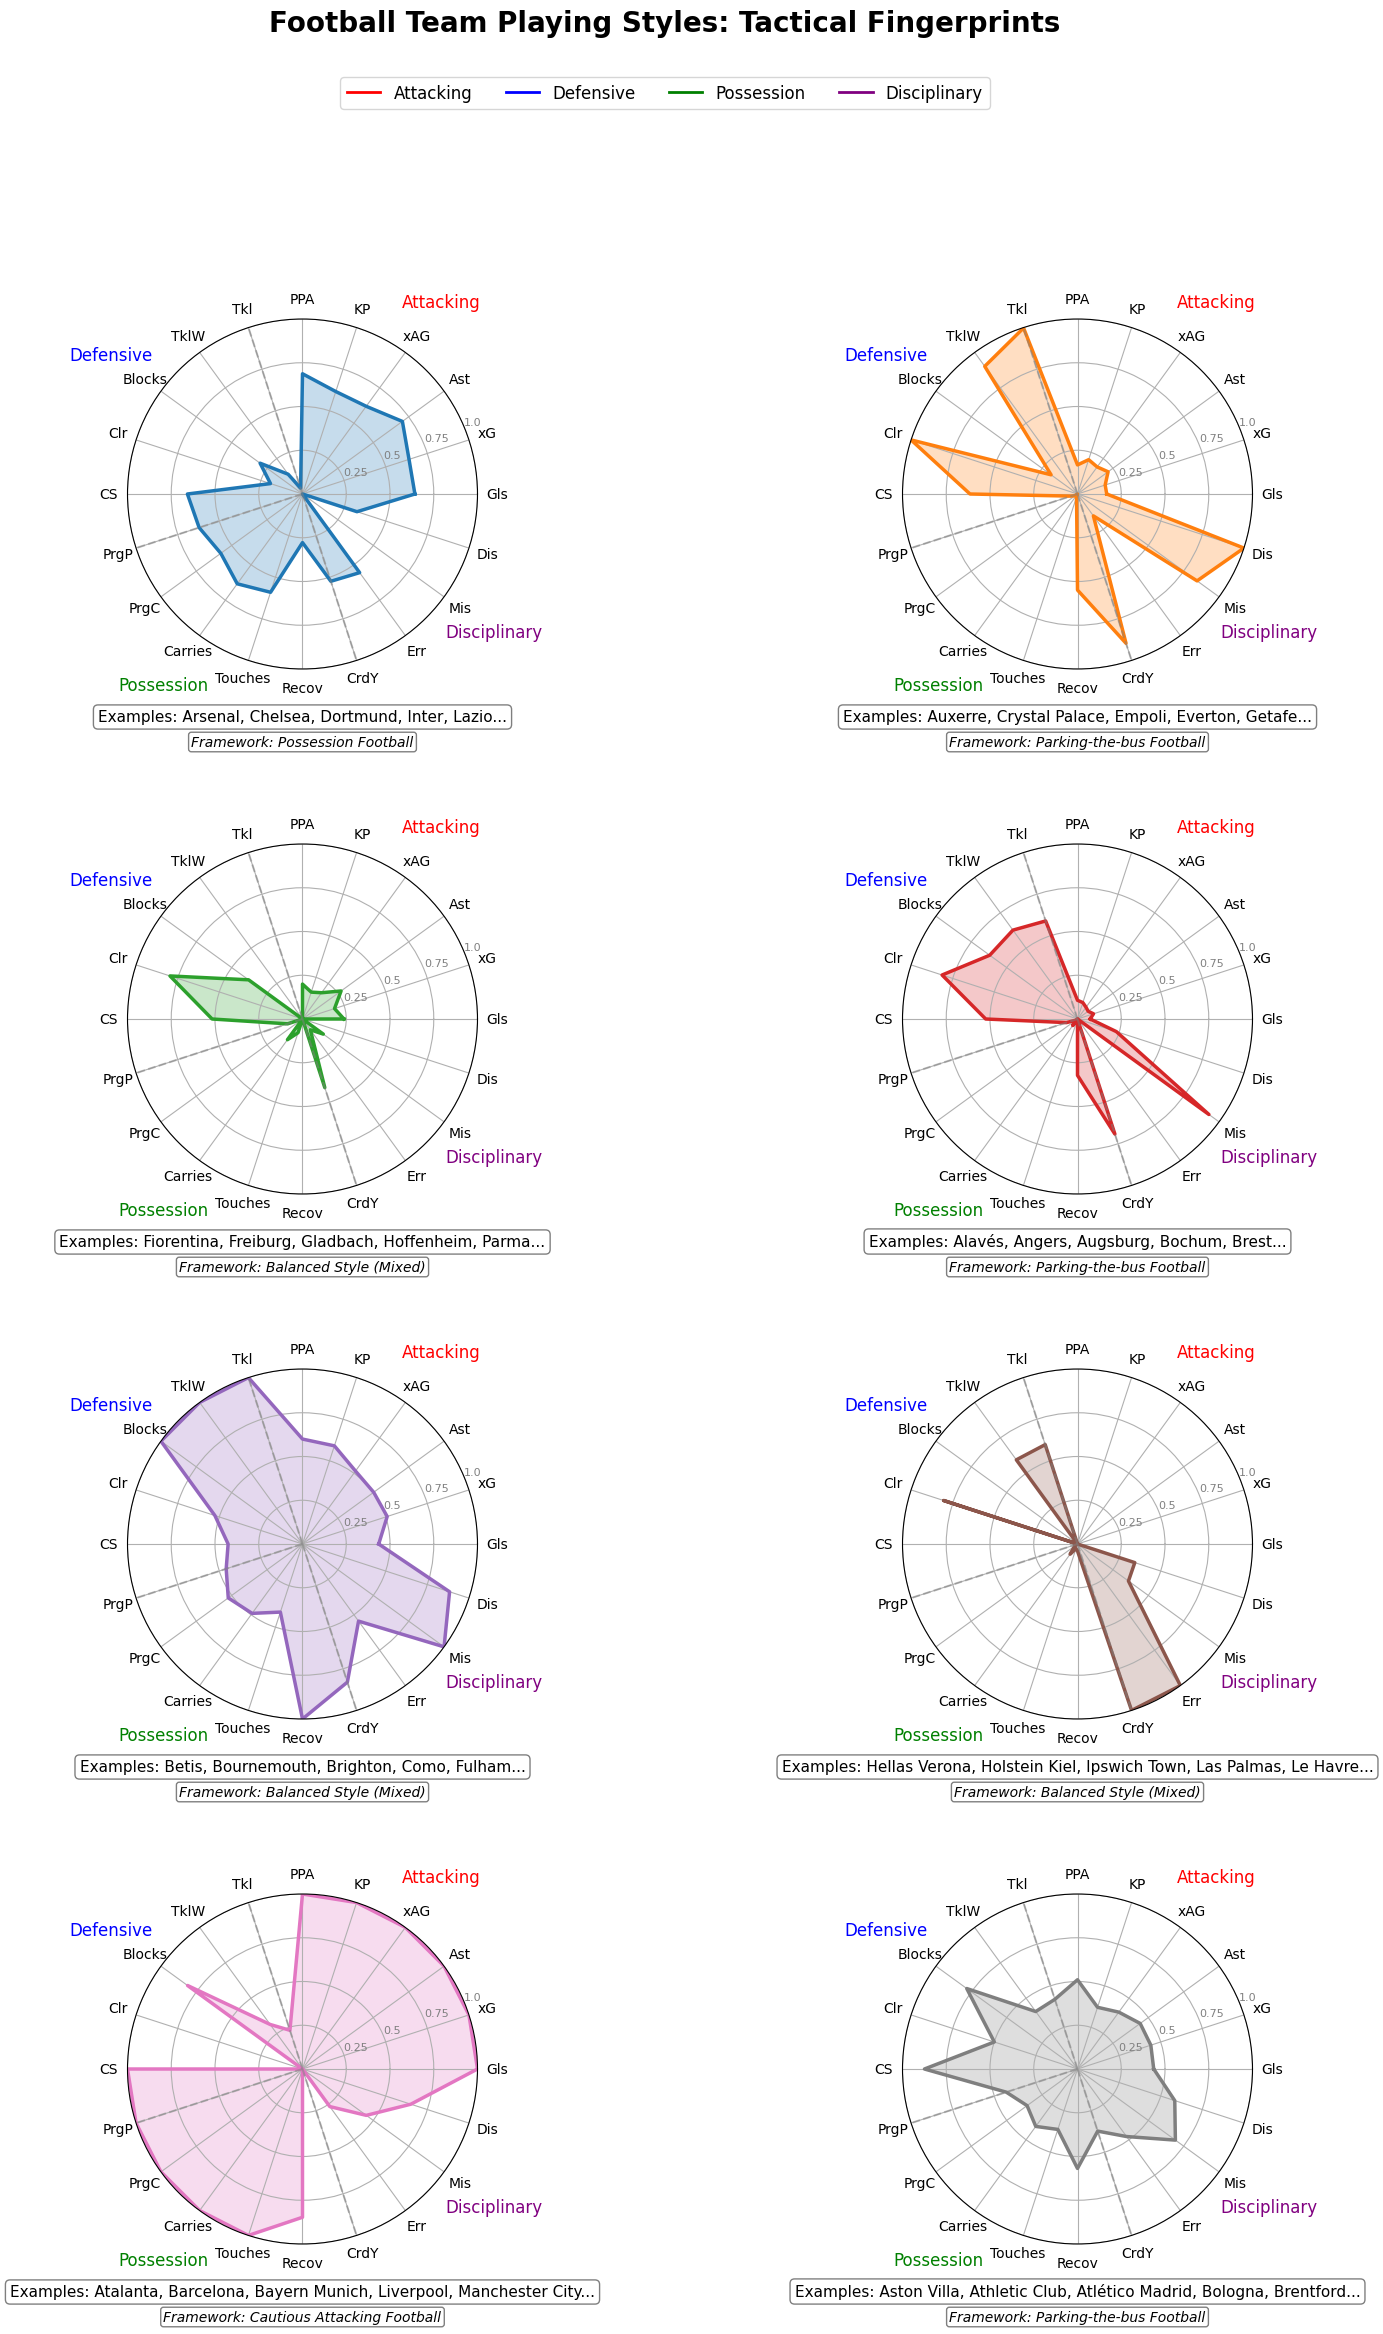

In [54]:

categories = {
    'Attacking': ['Gls', 'xG', 'Ast', 'xAG', 'KP', 'PPA'],
    'Defensive': ['Tkl', 'TklW', 'Blocks', 'Clr', 'CS'],
    'Possession': ['PrgP', 'PrgC', 'Carries', 'Touches', 'Recov'],
    'Disciplinary': ['CrdY', 'Err', 'Mis', 'Dis']
}

fig = plt.figure(figsize=(20, 25))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

for i, style_id in enumerate(range(8)):
    ax = fig.add_subplot(4, 2, i+1, polar=True)

    style_name = style_names[style_id]
    teams = team_df[team_df['PlayingStyle'] == style_id]['Squad'].tolist()

    values = []
    labels = []
    
    for category, metrics in categories.items():
        for metric in metrics:
            if metric in features:  
                idx = features.index(metric)
                values.append(normalized_centers[style_id][idx])
                labels.append(metric)
    
    N = len(values)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    values += values[:1]
    
    ax.plot(angles, values, linewidth=2.5, linestyle='solid', color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], fontsize=8, color='grey')
    ax.set_ylim(0, 1)
    
    current_idx = 0
    category_colors = {'Attacking': 'red', 'Defensive': 'blue', 
                      'Possession': 'green', 'Disciplinary': 'purple'}
    
    for category, metrics in categories.items():
        valid_metrics = [m for m in metrics if m in features]
        if valid_metrics:  
            
            if current_idx > 0:
                separator_angle = angles[current_idx]
                ax.plot([0, separator_angle], [0, 1], color='gray', linestyle='--', alpha=0.5)
            
            start_idx = current_idx
            end_idx = start_idx + len(valid_metrics)
            if start_idx < end_idx:  
                middle_idx = start_idx + (end_idx - start_idx) // 2
                if middle_idx < len(angles): 
                    middle_angle = angles[middle_idx]
                    
                    ax.text(middle_angle, 1.35, category, 
                            ha='center', va='center', fontsize=12, 
                            color=category_colors[category])
                
                current_idx = end_idx
    
    top_teams = ', '.join(teams[:5]) + ('...' if len(teams) > 5 else '')
    
    ax.text(0.5, -0.15, f"Examples: {top_teams}", 
            transform=ax.transAxes, ha='center', fontsize=11, 
            bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))

    match = next((p['Framework Match'] for p in style_profiles if p['Style ID'] == style_id), None)
    ax.text(0.5, -0.22, f"Framework: {match}", 
            transform=ax.transAxes, ha='center', fontsize=10, fontstyle='italic',
            bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.2'))

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Attacking'),
    Line2D([0], [0], color='blue', lw=2, label='Defensive'),
    Line2D([0], [0], color='green', lw=2, label='Possession'),
    Line2D([0], [0], color='purple', lw=2, label='Disciplinary')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98),
          ncol=4, fontsize=12)

plt.figtext(0.5, 0.995, "Football Team Playing Styles: Tactical Fingerprints", 
           ha='center', fontsize=20, fontweight='bold')

plt.subplots_adjust(hspace=0.5, wspace=0.0)
plt.savefig("comprehensive_playing_styles_radar.png", dpi=300, bbox_inches='tight')
plt.show()

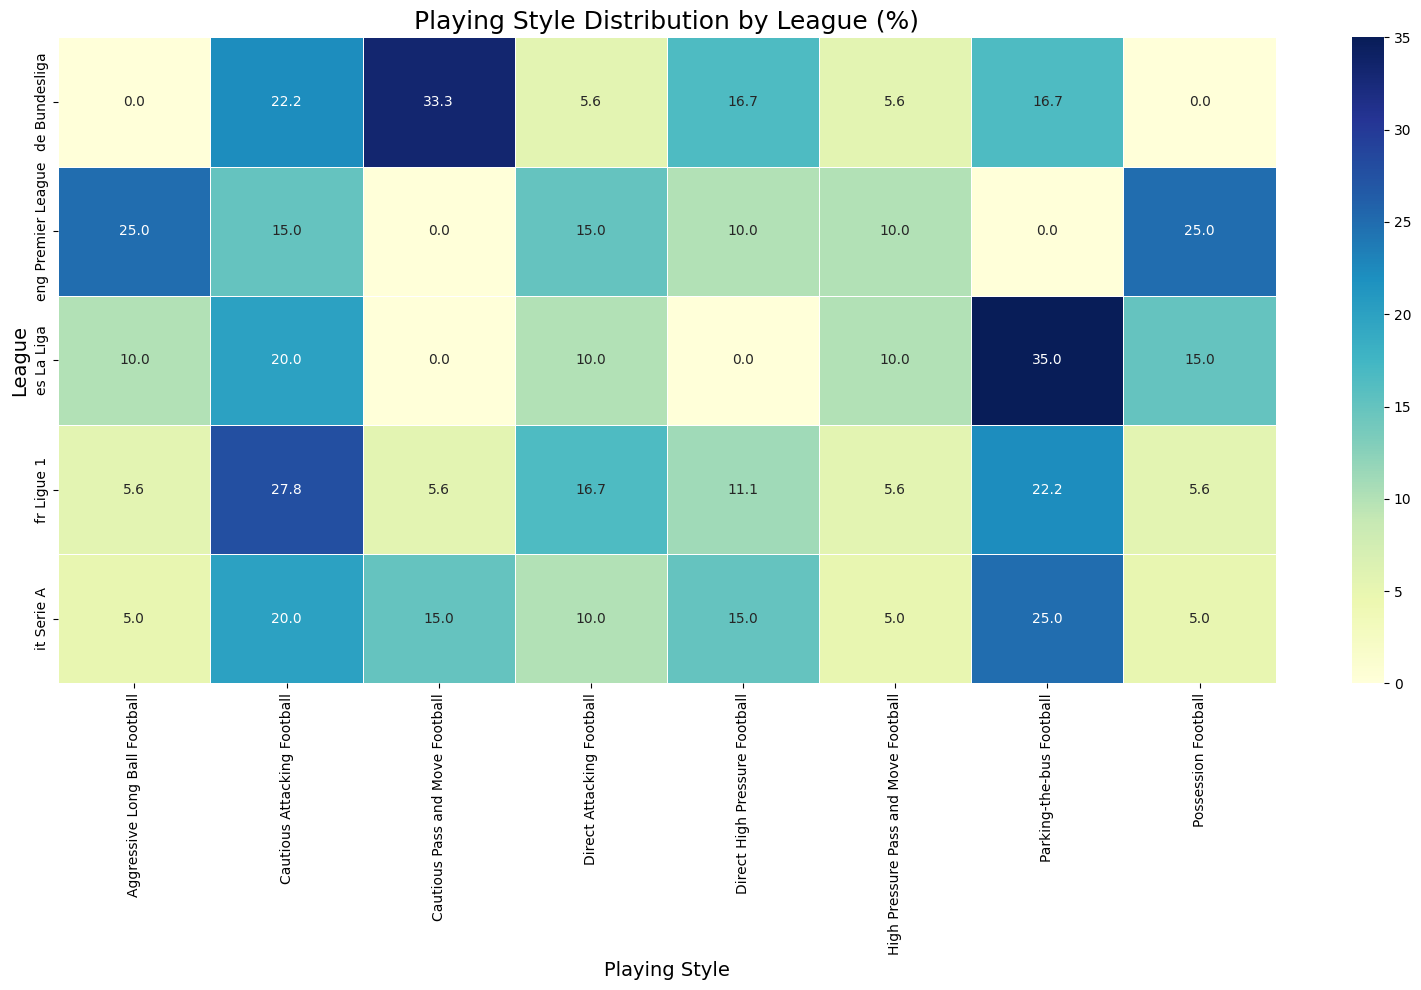

Dominant playing style by league:
Comp
de Bundesliga         Cautious Pass and Move Football
eng Premier League      Aggressive Long Ball Football
es La Liga                   Parking-the-bus Football
fr Ligue 1                Cautious Attacking Football
it Serie A                   Parking-the-bus Football
dtype: object


In [55]:
if 'Comp' in team_df.columns:
    
    league_style_counts = team_df.groupby(['Comp', 'StyleName']).size().unstack(fill_value=0)
    
    
    league_style_pct = league_style_counts.div(league_style_counts.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(16, 10))
    sns.heatmap(league_style_pct, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
    plt.title('Playing Style Distribution by League (%)', fontsize=18)
    plt.ylabel('League', fontsize=14)
    plt.xlabel('Playing Style', fontsize=14)
    plt.tight_layout()
    plt.savefig("league_style_distribution.png", dpi=300)
    plt.show()

    dominant_styles = league_style_pct.idxmax(axis=1)
    print("Dominant playing style by league:")
    print(dominant_styles)